In [165]:
import networkx as nx
import matplotlib.pyplot as plt

In [166]:
import matplotlib.cm as cm  # Para usar una paleta de colores continua
from networkx.drawing.nx_agraph import graphviz_layout

def mostrar_grafo(G):
    plt.figure(figsize=(10,10))  
    # Obtener todos los valores de profundidad para ajustar el rango de colores
    profundidades = [G.nodes[node].get('profundidad', 0) for node in G.nodes]
    
    # Normalizar las profundidades para asignar colores continuos en una escala
    min_prof, max_prof = min(profundidades), max(profundidades)
    colors = [
        cm.viridis((prof - min_prof) / (max_prof - min_prof)) if max_prof > min_prof else cm.viridis(0.5)
        for prof in profundidades
    ]
    
    nx.draw(G,with_labels=False, node_color=colors, edge_color="gray", node_size=2000, font_size=10)
    # Prepara las etiquetas con atributos de cada nodo
    labels = {node: f"n:{node}\np:{G.nodes[node].get('profundidad', '')}" for node in G.nodes}
    
    # Dibuja las etiquetas de los nodos con sus atributos
    nx.draw_networkx_labels(G, labels, font_size=15, font_color="white")
    
    plt.margins(0.2)
    plt.show()

In [167]:
def describir_arbol(G):
    def describir_arbol_aux(nodo, G, profundidad):
        hijos = list(G.successors(nodo))
        resultado = "\t"*profundidad+f"Nodo: {nodo} | Profundidad: {G.nodes[nodo]['profundidad']}\n"
        if hijos != []:
            for hijo in hijos:
                resultado+=describir_arbol_aux(hijo,G,profundidad+1)
        return resultado
    nodes = list(G.nodes)
    string = describir_arbol_aux(nodes[0],G,0)
    print(string)

In [168]:
def hojas_preorden(G):
    hojas = {n for n, out_d in G.out_degree() if out_d == 0}
    recorrido_preorden = list(nx.dfs_preorder_nodes(G, source=1))
    lista_hojas = [nodo for nodo in recorrido_preorden if nodo in hojas]
    return lista_hojas

#### Creación del grafo simultánea.
Al crear el grafo simultáneamente, se aprovecha la estructura del árbol para formarlo. Cada vez que el algoritmo de space partitioning selecciona un nodo y crea sus hijos en el árbol, se crean en esa misma iteración del bucle las conexiones de los nuevos nodos entre sí. Una vez esas conexiones están creadas, se conectan los nuevos nodos con las capas superiores:
> Si su padre tuvo hermanos('contiguos' != []), se conectan los hijos adyacentes a los hermanos con estos últimos, añadiendo también esta conexión al parámetro contiguos para conexiones más complejas en las que la diferencia de profundidad sea mayor que 1.
Problema: No se puede limitar la conexión de los hijos de diferentes nodos en el mismo nivel. Al ser "heredado" el atributo 'contiguos', se hereda la conexión con ambos nodos de abajo, cuando los nodos hijo estarían conectados con un solo nodo cada uno.

In [169]:
import random

def formar_particion_estado_4(n, d=5, semilla = None):
    
    # Para conseguir reproducibilidad, podemos introducir una semilla al algoritmo.
    if semilla is not None:
        random.seed(semilla)
    else:
        # Generar una seed aleatoria y almacenarla
        semilla = random.randint(0, 2**32 - 1)
        random.seed(semilla)  # Establecer la seed
    
    lista_hojas = []
        
    A = nx.DiGraph()
    A.add_node(1, profundidad=0)
    A.graph['altura'] = 0
    
    lista_hojas.append(1)
    nodos=1
    
    for i in range(1,n+1):
        if lista_hojas:
            #print(f"{i}: {lista_hojas}")
            selec = random.choice(lista_hojas)
            profundidad = nx.shortest_path_length(A, source=1,target=selec)+1
    
            if profundidad > A.graph['altura']:
                A.graph['altura'] = profundidad
            
            A.add_node(nodos+1,profundidad=profundidad)
            A.add_node(nodos+2,profundidad=profundidad)
            A.add_node(nodos+3,profundidad=profundidad)
            A.add_node(nodos+4,profundidad=profundidad)
            A.add_edges_from([(selec,nodos+1),(selec,nodos+2),(selec,nodos+3),(selec,nodos+4)])
            #print("Añadidos hijos "+str(nodos+1)+" y "+str(nodos+2))
            for i in range(1,5):
                profundidad = nx.shortest_path_length(A, source=1,target=nodos+i)+1
                if profundidad < d:
                    lista_hojas.append(nodos+i)
            
            lista_hojas.remove(selec)
            
            nodos+=4
    return A, semilla

In [170]:
import matplotlib.patches as patches
import os

class Cuadrado():
    def __init__(self, G, nodo=1, centro=None, tamaño=10, semilla = None):
        
        # Para conseguir reproducibilidad, podemos introducir una semilla al algoritmo.
        if semilla is not None:
            random.seed(semilla)
        else:  
            # Generar una seed aleatoria y almacenarla
            semilla = random.randint(0, 2**32 - 1)
            random.seed(semilla)  # Establecer la seed
        
        self.G=G
        self.S = nx.Graph()
        self.nodo = nodo
        self.tamaño = tamaño
        if centro is None:
            self.centro = (self.tamaño/2,self.tamaño/2)
        else:
            self.centro=centro
        self.tipo = 'pared'
        self.semilla = semilla
        self.nsalas = 0
        

        self.profundidad = self.G.graph['altura']
        
        # limites = [arriba,derecha,abajo,izquierda]
        offset = self.tamaño/2
        self.limites = [
            self.centro[1]+offset,
            self.centro[0]+offset,
            self.centro[1]-offset,
            self.centro[0]-offset
        ]

        self.cuadrantes = []
        self.hijos = []

        hijos = list(self.G.successors(nodo))

        if hijos:
            # Se divide por cuatro porque tiene la mitad de tamaño, y después se divide a la mitad otra vez para determinar el centro.
            mitad_tamaño = self.tamaño / 2
            centro_cuadrante = mitad_tamaño / 2
            offsets = [
                (-centro_cuadrante, centro_cuadrante),  # Cuadrante arriba izquierda
                (centro_cuadrante, centro_cuadrante),  # Cuadrante arriba derecha
                (-centro_cuadrante, -centro_cuadrante),  # Cuadrante abajo izquierda
                (centro_cuadrante, -centro_cuadrante)  # Cuadrante abajo derecha
            ]

            for hijo, offset in zip(hijos, offsets):
                nuevo_centro = (self.centro[0] + offset[0], self.centro[1] + offset[1])
                self.cuadrantes.append(Cuadrado(self.G, hijo, nuevo_centro, mitad_tamaño))
                
    def __str__(self):
        """
        Representación en texto del cuadrado.
        """
        return f"Cuadrado(nodo={self.nodo},tipo={self.tipo},límites={self.limites})"
            
    def formar_grafo(self):
        lista_hojas = self.hojas_preorden()
        for i in lista_hojas:
            #print(lista_hojas)
            yo = self.encontrar_cuadrante(i)
            #print(f"Hoja {yo.nodo}")
            if yo.nodo not in self.S.nodes:
                self.S.add_node(yo.nodo)
                self.S.nodes[yo.nodo]['arriba'] = []
                self.S.nodes[yo.nodo]['derecha'] = []
                self.S.nodes[yo.nodo]['izquierda'] = []
                self.S.nodes[yo.nodo]['abajo'] = []
                self.S.nodes[yo.nodo]['tamaño'] = self.profundidad - self.G.nodes[yo.nodo]['profundidad']
                
            for j in lista_hojas:
                tu = self.encontrar_cuadrante(j)
                #print(f"\tHoja {tu.nodo}")
                
                if tu.nodo not in self.S.nodes:
                    self.S.add_node(tu.nodo)
                    self.S.nodes[tu.nodo]['arriba'] = []
                    self.S.nodes[tu.nodo]['derecha'] = []
                    self.S.nodes[tu.nodo]['izquierda'] = []
                    self.S.nodes[tu.nodo]['abajo'] = []
                    self.S.nodes[tu.nodo]['tamaño'] = self.profundidad - self.G.nodes[tu.nodo]['profundidad']
                
                if i == j:
                    #print("Comparación de iguales")
                    continue
                
                # Conexión hacia arriba
                if yo.limites[0] == tu.limites[2]:
                    #print("\tLimites superior e inferior coinciden.")
                    if yo.limites[1] >= tu.limites[1] and yo.limites[3] <= tu.limites[3]:
                        self.S.add_edge(tu.nodo,yo.nodo)
                        if tu.nodo not in self.S.nodes[yo.nodo]['arriba']:
                            self.S.nodes[yo.nodo]['arriba'].append(tu.nodo)
                        if yo.nodo not in self.S.nodes[tu.nodo]['abajo']:
                            self.S.nodes[tu.nodo]['abajo'].append(yo.nodo)
                        #print(f"\tConecta con {tu.nodo}")
                
                # Conexión hacia la derecha
                if yo.limites[1] == tu.limites[3]:
                    #print("\tLimites derecha e izquierda coinciden.")
                    if yo.limites[0] <= tu.limites[0] and yo.limites[2] >= tu.limites[2]:
                        self.S.add_edge(tu.nodo,yo.nodo)
                        if tu.nodo not in self.S.nodes[yo.nodo]['derecha']:
                            self.S.nodes[yo.nodo]['derecha'].append(tu.nodo)
                        if yo.nodo not in self.S.nodes[tu.nodo]['izquierda']:
                            self.S.nodes[tu.nodo]['izquierda'].append(yo.nodo)
                        #print(f"\tConecta con {tu.nodo}")
                        
                # Conexión hacia abajo
                if yo.limites[2] == tu.limites[0] :
                    #print("\tLimites superior e inferior coinciden.")
                    if yo.limites[1] >= tu.limites[1] and yo.limites[3] <= tu.limites[3]:
                        self.S.add_edge(tu.nodo,yo.nodo)
                        if tu.nodo not in self.S.nodes[yo.nodo]['abajo']:
                            self.S.nodes[yo.nodo]['abajo'].append(tu.nodo)
                        if yo.nodo not in self.S.nodes[tu.nodo]['arriba']:
                            self.S.nodes[tu.nodo]['arriba'].append(yo.nodo)
                        #print(f"\tConecta con {tu.nodo}")
                        
                # Conexión hacia la izquierda
                if yo.limites[3] == tu.limites[1]:
                    #print("\tLimites derecha e izquierda coinciden.")
                    if yo.limites[0] <= tu.limites[0] and yo.limites[2] >= tu.limites[2]:
                        self.S.add_edge(tu.nodo,yo.nodo)
                        if tu.nodo not in self.S.nodes[yo.nodo]['izquierda']:
                            self.S.nodes[yo.nodo]['izquierda'].append(tu.nodo)
                        if yo.nodo not in self.S.nodes[tu.nodo]['derecha']:
                            self.S.nodes[tu.nodo]['derecha'].append(yo.nodo)
                        #print(f"\tConecta con {tu.nodo}")
                
    def encontrar_cuadrante(self, id):
        """
        Busca el cuadrante que contiene el nodo con el ID especificado.
        Imprime un mensaje si no lo encuentra y detiene la búsqueda.
        """
        if self.nodo == id:
            #print(f"Nodo encontrado: {self.nodo}")
            return self
    
        for cuadrante in self.cuadrantes:
            resultado = cuadrante.encontrar_cuadrante(id)
            if resultado:
                return resultado
            
        return None
            
    def hojas_preorden(self):
        hojas = {n for n, out_d in self.G.out_degree() if out_d == 0}
        recorrido_preorden = list(nx.dfs_preorder_nodes(self.G, source=1))
        return [nodo for nodo in recorrido_preorden if nodo in hojas]
    
    def crear_mazmorra_clasica(self, n=5, densidad = 1):
        def generar_expansiones(nodos,selec):
            direcciones_pequeño = set()
            direcciones_mismo = set()
            pares_contiguos = {("arriba", "derecha"), ("derecha", "abajo"), ("abajo", "izquierda"), ("izquierda", "arriba"), }   
            # E00
            expansiones = {"E00":[selec]}
            
            for attr, vecinos in nodos[selec].items():
                if attr == 'tamaño':
                    continue  # Saltar la clave 'tamaño'
                    
                tamaño_menor = []
                tamaño_igual = []
                
                for nodo in vecinos:
                    if nodos[nodo]['tamaño'] == nodos[selec]['tamaño']-1:
                        tamaño_menor.append(nodo)
                    elif nodos[nodo]['tamaño'] == nodos[selec]['tamaño']:
                        tamaño_igual.append(nodo)
                        
                if len(tamaño_menor) == 2:
                    direcciones_pequeño.add(attr)
                    expansiones[f"E01_{attr}"] = [selec] + tamaño_menor
        
                if tamaño_igual:
                    direcciones_mismo.add(attr)
                    expansiones[f"E04_{attr}"] = [selec] + tamaño_igual
            
            arriba = nodos[selec]['arriba']
            abajo = nodos[selec]['abajo']
            mapa_indices = {
                ("arriba", "derecha"): (arriba, 'derecha', 1),
                ("derecha", "abajo"): (abajo, 'derecha', 1),
                ("abajo", "izquierda"): (abajo, 'izquierda', 0),
                ("izquierda", "arriba"): (arriba, 'izquierda', 0)
            }
            # Direcciones de expansión contiguas
            for d1, d2 in pares_contiguos:
                
                if {d1,d2}.issubset(direcciones_pequeño):
                    expansiones[f"E02_{d1}_{d2}"] = [selec] + nodos[selec][d1] + nodos[selec][d2]
                    if (d1,d2) in mapa_indices:
                        nodo_y, nodo_x, indice = mapa_indices[(d1,d2)]
                        esquina = nodos[nodo_y[indice]][nodo_x][0]
                        if nodos[esquina]['tamaño'] == nodos[selec]['tamaño'] - 1:
                            expansiones[f"E03_{d1}_{d2}"] = [selec] + nodos[selec][d1] + nodos[selec][d2] + [esquina]
                            
                if {d1,d2}.issubset(direcciones_mismo):
                    expansiones[f"E05_{d1}_{d2}"] = [selec] + nodos[selec][d1] + nodos[selec][d2]
                    if (d1,d2) in mapa_indices:
                        nodo_y, nodo_x, indice = mapa_indices[(d1,d2)]
                        esquina = nodos[nodo_y[0]][nodo_x][0]
                        if nodos[esquina]['tamaño'] == nodos[selec]['tamaño']:
                            expansiones[f"E03_{d1}_{d2}"] = [selec] + nodos[selec][d1] + nodos[selec][d2] + [esquina]
                            
            if {"arriba", "derecha", "abajo", "izquierda"}.issubset(direcciones_mismo):
                esquinas = {
                    "arriba_derecha": nodos[arriba[0]]['derecha'][0],
                    "derecha_abajo": nodos[abajo[0]]['derecha'][0],
                    "abajo_izquierda": nodos[abajo[0]]['izquierda'][0],
                    "izquierda_arriba": nodos[arriba[0]]['izquierda'][0]
                }
                del esquina
                if all(nodos[esquina]['tamaño'] == nodos[selec]['tamaño'] for esquina in esquinas.values()):
                    expansiones[f"E07"] = (
                            [selec] + 
                            nodos[selec]['arriba'] + nodos[selec]['derecha'] + nodos[selec]['abajo'] + nodos[selec]['izquierda'] + 
                            list(esquinas.values()))
        
            return dict(sorted((expansiones.items())))
        
        def seleccionar_expansion(expansiones):
            #TODO: selección por tamaño
            if not expansiones:
                return False
            while expansiones:
                expansion = random.choice(list(expansiones.keys()))
                #print(f"\tExpansion: {expansion}")
                if all(self.comprobar_adyacentes(nodo, densidad) for nodo in expansiones[expansion]):
                    #print(f"\t\tEs válida")
                    for nodo in expansiones[expansion]:
                        if nodo in lista_hojas:
                            lista_hojas.remove(nodo)
                        self.encontrar_cuadrante(nodo).tipo = 'suelo'
                    print(f"SELECCIONADO {selec} con la expansión {expansion}\n")
                    return True
                #print(f"\t\tNo es válida")
                del expansiones[expansion]
                #print(f"\tExpansión: {expansion}")
            return False
        
        
        lista_hojas = set(self.hojas_preorden())
        nodos = self.S.nodes
        max_intentos = 100

        for i in range(n):
            intentos = 0
            while intentos < max_intentos:
                if not lista_hojas:
                    #print("No hay más hojas disponibles")
                    return
                
                selec = random.choice(list(lista_hojas))
                nodo_selec = self.encontrar_cuadrante(selec)
                #print(f"Nodo {selec} seleccionado")
                
                if nodo_selec.tipo != 'suelo':
                    #print("\tNo era suelo")
                    expansiones = generar_expansiones(nodos, selec)
                    #print(f"\tExpansiones: {expansiones}")
                    
                    if seleccionar_expansion(expansiones):
                        break

                intentos += 1
            if intentos >= max_intentos:
                print("Límite alcanzado")
                print(f"Salas creadas: {i}")
                break

    def comprobar_adyacentes(self, nodo, densidad = 1):
        # Si la profundidad llega a 0, no se revisan más vecinos
        if densidad == 0:
            return True
    
        # Se obtiene la lista de vecinos del nodo
        for vecino in list(self.S.neighbors(nodo)):
            cuadrante = self.encontrar_cuadrante(vecino)
            
            # Si el vecino directo es 'suelo', retornamos False
            if cuadrante.tipo == 'suelo':
                return False
            
            # Llamada recursiva para los vecinos de los vecinos, con la profundidad decrementada
            if not self.comprobar_adyacentes(vecino, densidad - 1):
                return False
    
        # Si todos los vecinos y vecinos de los vecinos hasta la profundidad son válidos, retornamos True
        return True
    
    def get_vecinos(self, n):
        nodos = self.S.nodes
        dict_items=list(nodos[n].items())[:-1]
        vecinos = []
        
        for item in dict_items:
            if item[1]:
                for i in item[1]:
                    vecinos.append(i)
        return vecinos
    
    def crear_mazmorra_dikjstra(self, n = 5):
        pintados = []
        lista_hojas = self.hojas_preorden()
        print(f"Lista de hojas: {lista_hojas}")
        
        inicio = random.choice(lista_hojas)
        fin = random.choice(lista_hojas)
        while inicio == fin:
            fin = random.choice(lista_hojas)
        
        print(f"Camino de {inicio} a {fin}:")
        camino = nx.shortest_path(self.S, source = inicio, target = fin)
        print(camino)
        
        for nodo in camino:
            pintados.append(nodo)
            print(f"\tNodo: {nodo} pintado")
            cuadrante = self.encontrar_cuadrante(nodo)
            cuadrante.tipo='suelo'
            
        for i in range(n-1):
            inicio = random.choice(lista_hojas)
            fin = random.choice(pintados)
            while inicio == fin:
                fin = random.choice(pintados)
            
            print(f"Camino de {inicio} a {fin}:")
            camino = nx.shortest_path(self.S, source = inicio, target = fin)
            print(camino)
            
            for nodo in camino:
                print(f"\tNodo: {nodo} pintado")
                cuadrante = self.encontrar_cuadrante(nodo)
                cuadrante.tipo='suelo'

    def imprimir_estructura(self, nivel=0):
        """
        Imprime la estructura jerárquica del cuadrado.
        """
        print(" " * nivel * 4 + str(self))
        for cuadrante in self.cuadrantes:
            cuadrante.imprimir_estructura(nivel + 1)
            
    def dibujar_grafo(self):
        """ Dibuja el grafo de conectividad de las salas """
        pos = {nodo: (self.encontrar_cuadrante(nodo).centro) for nodo in self.S.nodes}
        
        plt.figure(figsize=(self.tamaño, self.tamaño))
        nx.draw(self.S, pos, with_labels=True, node_size=500, node_color="lightblue", edge_color="grey")
        plt.show()
    
    def dibujar(self, guardar = False):   
        
        def dibujar_aux(raiz, ax, transparente):
            if not raiz.cuadrantes:
                # Dibuja el cuadrado actual
                x, y = raiz.centro
                tamaño = raiz.tamaño
                
                colores = {
                    'pared': 'black',
                    'suelo': 'white',
                    'borde': ('grey' if transparente else 'None')
                }
                    
                rect = patches.Rectangle(
                    (x - tamaño / 2, y - tamaño / 2), tamaño, tamaño,
                    linewidth=1, edgecolor=colores['borde'], facecolor=colores[raiz.tipo]
                )
                ax.add_patch(rect)
                
                if transparente:
                    ax.text(x, y, str(raiz.nodo), color='grey', fontsize=raiz.tamaño*5, ha='center', va='center')
    
            # Dibujar los hijos
            for cuadrante in raiz.cuadrantes:
                dibujar_aux(cuadrante,ax,transparente)
                
        fig, (ax1, ax2) = plt.subplots(figsize=(self.tamaño*2, self.tamaño),ncols=2)
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(.2)  # Fondo de la figura transparente
        
        for ax,transparente in [(ax1,True),(ax2,False)]:
            ax.set_xlim(0, self.tamaño)
            ax.set_ylim(0, self.tamaño)
            ax.set_aspect('equal')
            ax.axis('off')
            ax.set_title(str(self.semilla))
            dibujar_aux(self,ax,transparente)
        
        if guardar:
            carpeta = f"Cuadrados"
            if not os.path.exists(carpeta):
                os.makedirs(carpeta)
            
            # Guardar la figura en la carpeta con el nombre basado en la semilla
            archivo_guardado = os.path.join(
                carpeta, 
                f"figura_{self.semilla}_SpacePart_{self.nsalas}.svg"
            )
            fig.savefig(archivo_guardado, transparent=False, bbox_inches='tight')
            
            print(f"Figura guardada en: {archivo_guardado}")

In [194]:
def crear_mazmorra_space_part(arquitectura, npart = 20, prof_division = 5, nsalas = 5, densidad = 1, guardar = False):
    if densidad > 3 or densidad < 0:
        print("La densidad debe estar entre 0 y 3")
        return 
    A, semilla = formar_particion_estado_4(npart, d = prof_division)
    cuadrado = Cuadrado(A,semilla=semilla)
    #cuadrado.imprimir_estructura()
    cuadrado.formar_grafo()
    if arquitectura == 'clasica':
        cuadrado.crear_mazmorra_clasica(nsalas, densidad=4-densidad)
        pass
    elif arquitectura == 'dikjstra':
        cuadrado.crear_mazmorra_dikjstra(nsalas)
    cuadrado.dibujar(guardar=guardar)
    return cuadrado

Lista de hojas: [202, 382, 383, 384, 385, 526, 527, 528, 529, 205, 582, 583, 584, 585, 558, 559, 560, 561, 372, 373, 302, 303, 304, 305, 162, 163, 164, 165, 418, 419, 420, 421, 354, 355, 356, 357, 106, 107, 108, 109, 438, 534, 535, 536, 537, 440, 470, 471, 472, 473, 435, 436, 437, 590, 591, 592, 593, 574, 575, 576, 577, 572, 573, 358, 359, 360, 361, 174, 175, 176, 177, 222, 223, 224, 225, 390, 391, 392, 393, 338, 339, 340, 341, 294, 295, 296, 297, 498, 499, 500, 501, 306, 307, 308, 309, 458, 459, 460, 461, 191, 246, 247, 248, 249, 378, 379, 380, 381, 422, 423, 424, 425, 334, 335, 336, 337, 482, 483, 484, 485, 145, 10, 414, 415, 416, 417, 490, 491, 492, 493, 598, 599, 600, 601, 314, 315, 316, 317, 402, 403, 404, 405, 150, 151, 152, 153, 126, 127, 128, 129, 112, 206, 207, 208, 209, 114, 115, 116, 117, 58, 59, 60, 61, 454, 455, 456, 457, 194, 195, 196, 197, 566, 567, 568, 569, 486, 487, 488, 489, 342, 343, 344, 345, 200, 201, 442, 443, 444, 445, 394, 395, 396, 397, 446, 447, 448, 449, 254

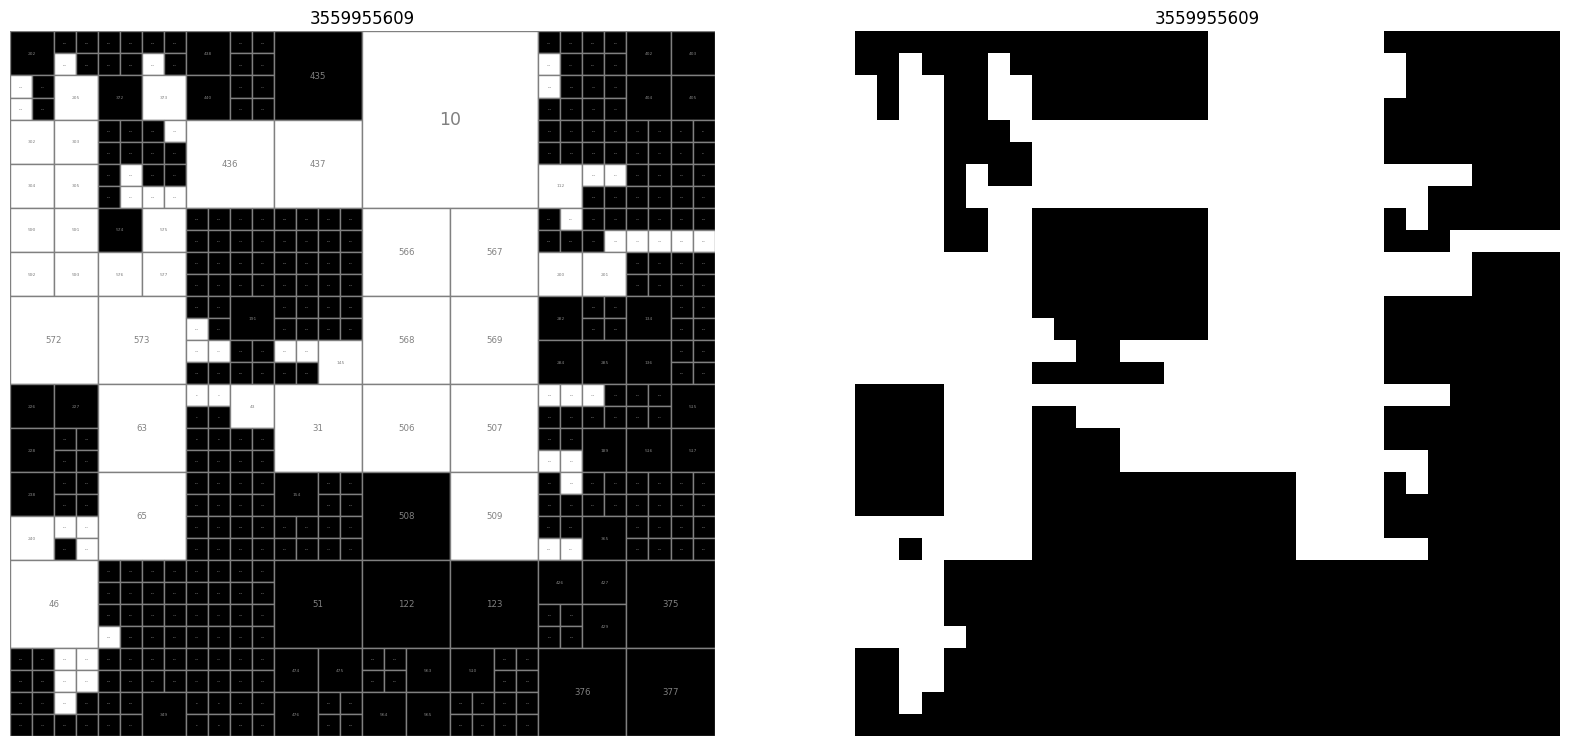

In [207]:
# 'dikjstra', 'clasica'
arquitectura = 'dikjstra'
npart = 150
prof = 6
nsalas = 20
densidad = 2
guardar = False

cuadrado=crear_mazmorra_space_part(
    arquitectura = arquitectura,
    npart=npart,
    prof_division=prof,
    nsalas=nsalas,
    densidad=densidad,
    guardar=guardar
)